Import modules.

In [1]:
from mica_text_coref.coref.seq_coref import data
from mica_text_coref.coref.seq_coref import data_util

import collections
from matplotlib import pyplot as plt
import numpy as np
import random
from transformers import BertTokenizer
import tqdm
from typing import Callable

plt.rcParams.update({"font.size": 14,
                     "font.family": "sans-serif",
                     "figure.figsize": (15, 6),
                     "axes.facecolor": "212121",
                     "figure.dpi"       : 200,
                     "legend.fontsize"  : "medium",
                     "figure.titlesize" : "medium",
                     "lines.linewidth": 2,
})

Load Bert Tokenizer base cased.

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Load train, dev, test English corpora and combine them.

In [3]:
train_corpus = data_util.load_data(("/home/sbaruah_usc_edu/mica_text_coref/"
    "data/conll-2012/gold/train.english.jsonlines"))
dev_corpus = data_util.load_data(("/home/sbaruah_usc_edu/mica_text_coref/"
    "data/conll-2012/gold/dev.english.jsonlines"))
test_corpus = data_util.load_data(("/home/sbaruah_usc_edu/mica_text_coref/"
    "data/conll-2012/gold/test.english.jsonlines"))

corpus = train_corpus + dev_corpus + test_corpus
print(f"Total number of documents = {len(corpus)}")

Total number of documents = 3493


Remap spans to use bert tokenizer

In [4]:
bert_corpus = data_util.remap_spans(corpus, bert_tokenizer.tokenize)

100%|██████████| 3493/3493 [00:55<00:00, 62.44it/s] 


Print functionals and draw histogram.

In [5]:
def functionals(arr: np.ndarray) -> list[float]:
  mean = np.mean(arr)
  min = np.min(arr)
  max = np.max(arr)
  std = np.std(arr)
  median = np.median(arr)
  quantile75 = np.quantile(arr, 0.75)
  quantile90 = np.quantile(arr, 0.90)
  quantile95 = np.quantile(arr, 0.95)
  return [mean, std, min, max, median, quantile75, quantile90, quantile95]

def print_functionals(arr, desc):
  arr = np.array(arr)
  mean, std, min, max, med, q75, q90, q95 = functionals(arr)
  print(f"{desc}:")
  print(f"\t{'Mean +- std':20s}    = {mean:.2f} +- {std:.2f}")
  print(f"\t{'[Min, Max]':20s}    = [{min}, {max}]")
  print(f"\tquantiles: 50% (median) = {med:.2f}, 75% = {q75:.2f}, "
        f"90% = {q90:.2f}, 95% = {q95:.2f}")
  print()

def draw_histogram(arr, var="x", bins=10, disable_bar_labels=False, 
                   return_histogram=False, **kwargs):
  narr, bins, patches = plt.hist(arr, bins=bins, color="c", **kwargs)
  plt.xlabel(var)
  plt.ylabel("frequency")
  plt.title(f"Histogram of {var}")
  s = len(arr)

  if not disable_bar_labels:
    for i in range(len(patches)):
      xx = patches[i].get_x()
      height = patches[i].get_height()
      width = patches[i].get_width()
      text = f"[{bins[i]:.1f}, {bins[i + 1]:.1f})"
      if i == len(patches) - 1:
        text = f"[{bins[i]:.0f}, {bins[i + 1]:.0f}]"
      plt.text(xx + width/2, height, text, ha="center", va="bottom", 
              fontsize=12, color="w")
      plt.text(xx + width/2, height, f"{100*height/s:.1f}%", ha="center",
              va="top", fontsize=8, color="k")
  
  plt.show()

  if return_histogram:
    return narr, bins, patches

def describe(arr, desc, **kwargs):
  print_functionals(arr, desc)
  return draw_histogram(arr, var=desc, **kwargs)

Find some descriptive statistics of the coreference corpus.

In [6]:
n_tokens_per_document = []
n_tokens_per_sentence = []
n_clusters_per_document = []
n_mentions_per_cluster = []
n_clusters_per_500_tokens = []

n_tokens_between_successive_mentions = []
n_tokens_between_first_and_last_mention = []

for document in tqdm.tqdm(bert_corpus.documents):
    n_tokens = 0
    for sentence in document.sentences:
        n_tokens_per_sentence.append(len(sentence))
        n_tokens += len(sentence)
    n_tokens_per_document.append(n_tokens)
    n_clusters_per_document.append(len(document.clusters))
    n_clusters_per_500_tokens.append(500*len(document.clusters)/n_tokens)
    
    for cluster in document.clusters:
        n_mentions_per_cluster.append(len(cluster))
        sorted_cluster = sorted(cluster)
        for i in range(len(cluster) - 1):
            gap = sorted_cluster[i + 1].begin - sorted_cluster[i].end - 1
            n_tokens_between_successive_mentions.append(gap)
        if len(cluster) > 1:
            n_tokens_between_first_and_last_mention.append(
                sorted_cluster[-1].end - sorted_cluster[0].begin + 1)
        else:
            n_tokens_between_first_and_last_mention.append(0)

100%|██████████| 3493/3493 [00:00<00:00, 16705.53it/s]


Number of tokens per document.

Number of tokens per document:
	Mean +- std             = 522.82 +- 413.57
	[Min, Max]              = [25, 4924]
	quantiles: 50% (median) = 440.00, 75% = 734.00, 90% = 1045.00, 95% = 1205.00



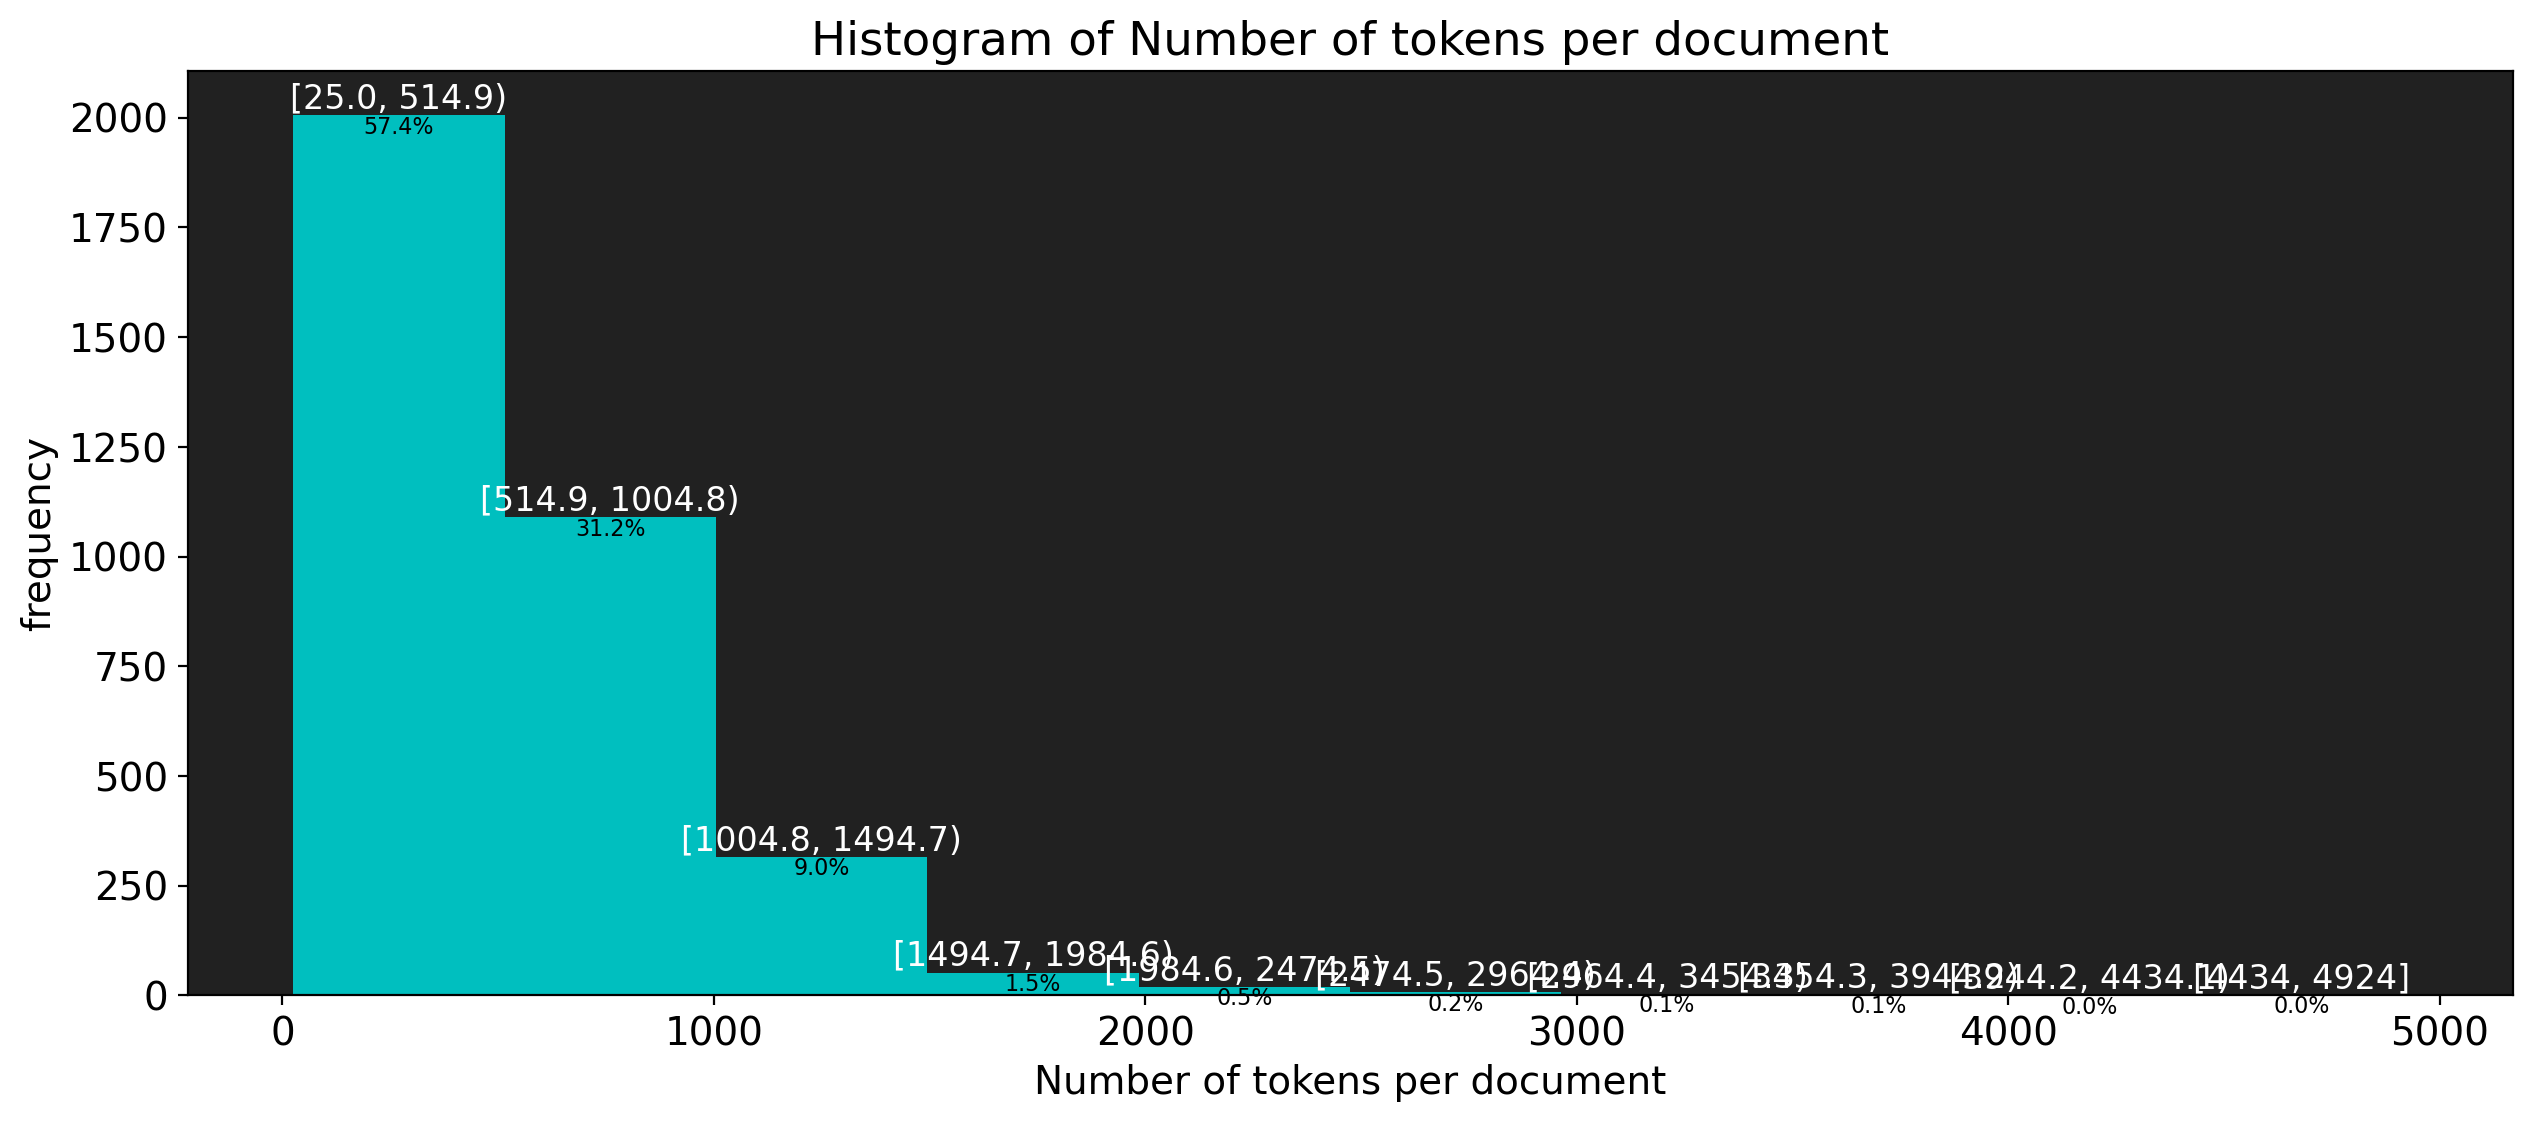

In [7]:
describe(n_tokens_per_document, "Number of tokens per document")

Number of coreference clusters per document.

Number of coreference chains per document:
	Mean +- std             = 12.53 +- 9.76
	[Min, Max]              = [0, 94]
	quantiles: 50% (median) = 10.00, 75% = 18.00, 90% = 25.00, 95% = 30.00



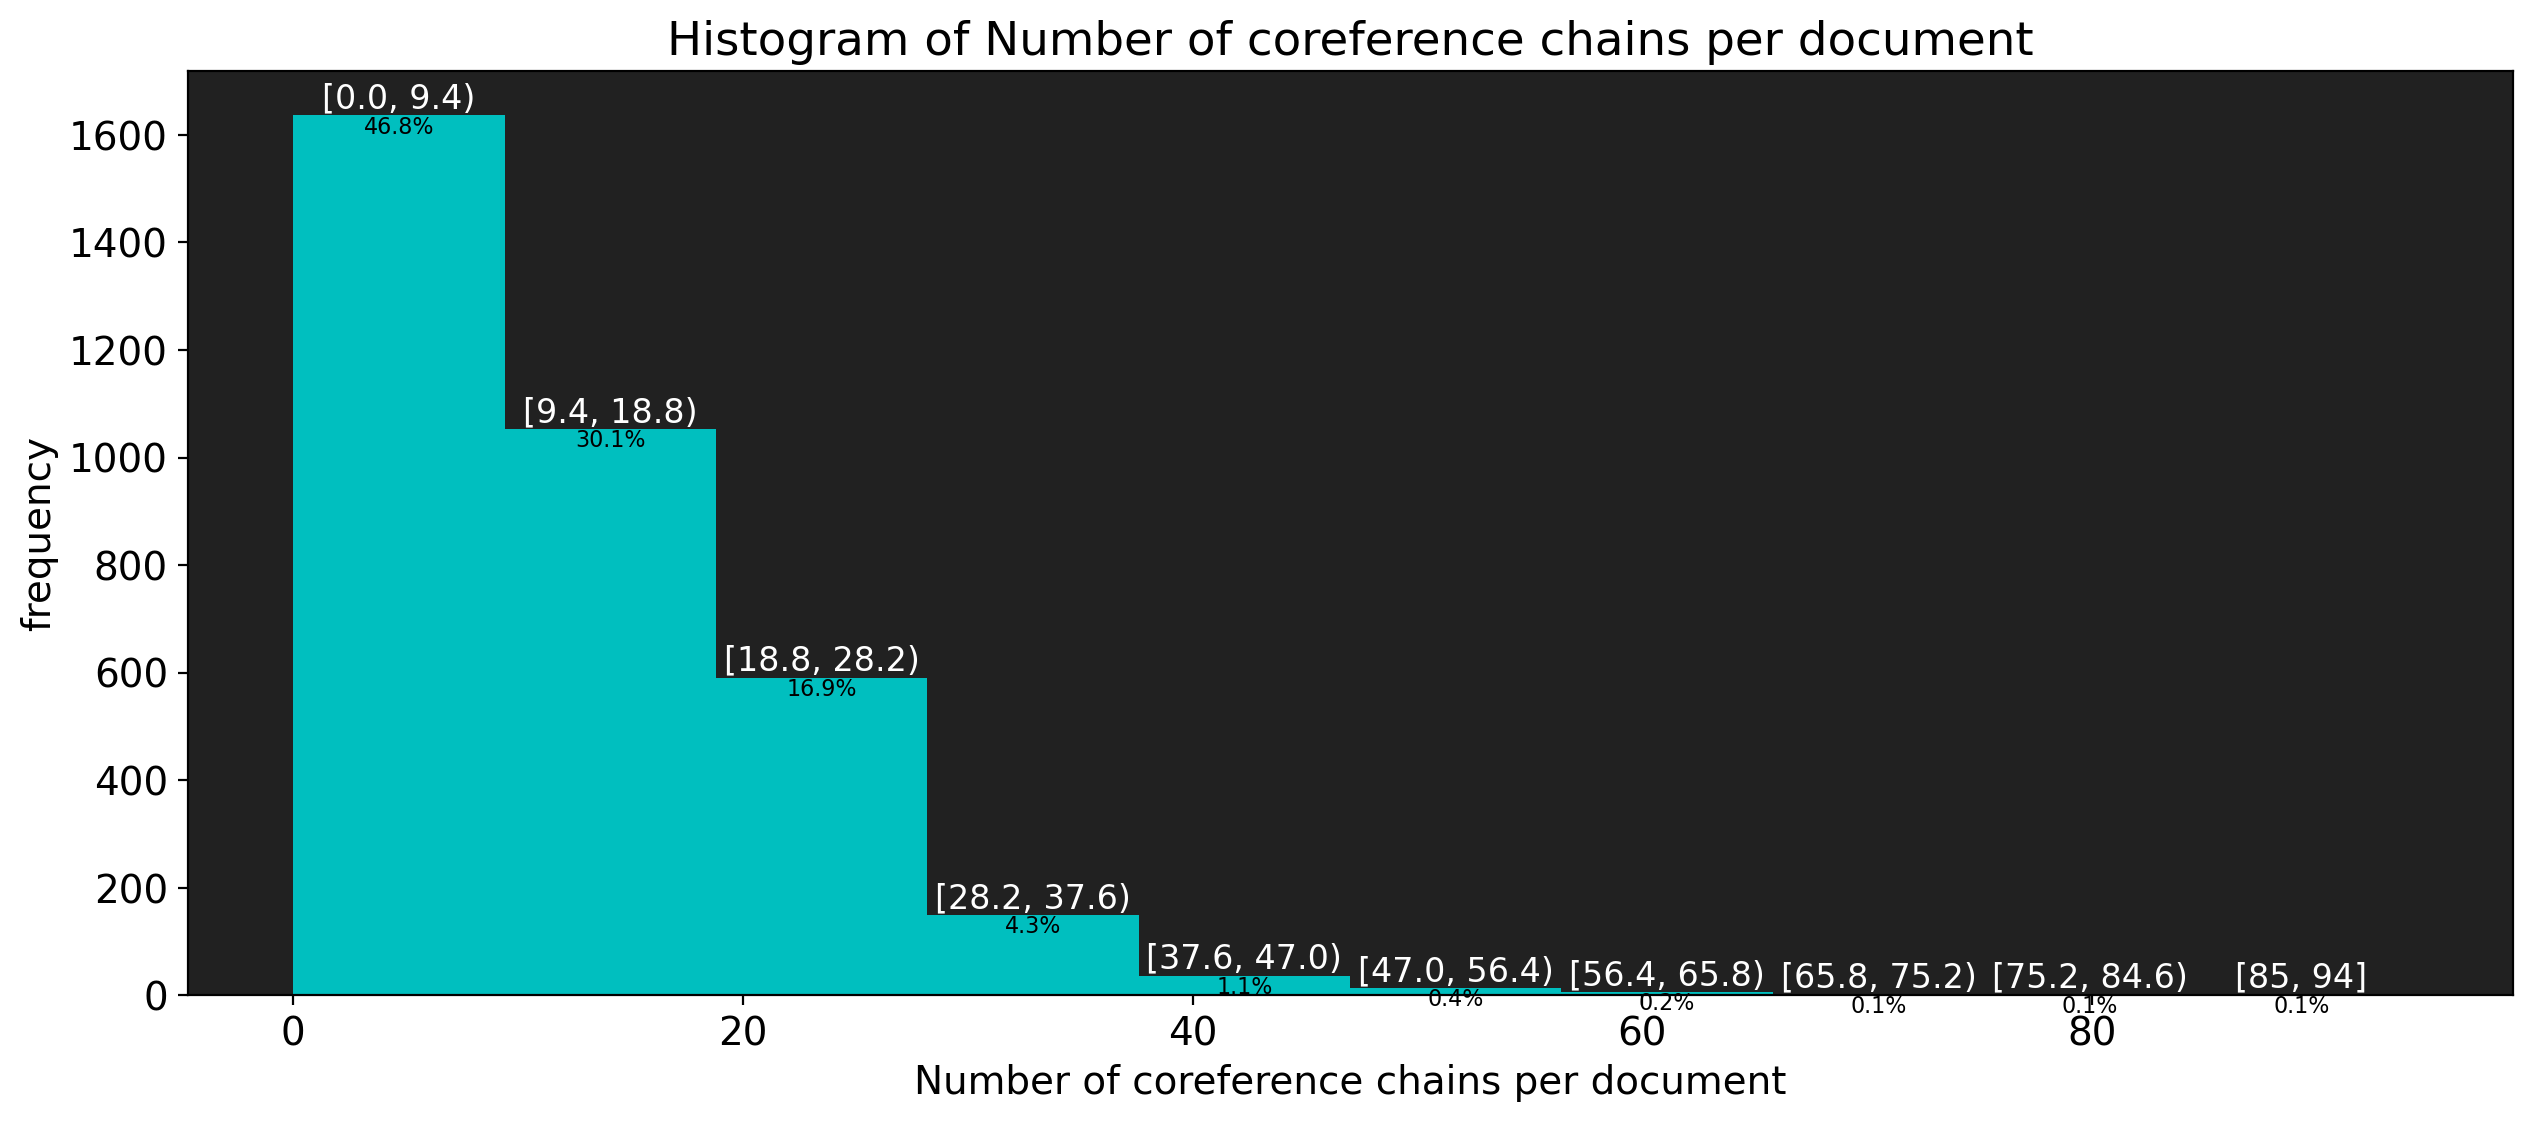

In [8]:
describe(n_clusters_per_document, "Number of coreference chains per document")

Numner of coreference clusters per 500 tokens

Number of clusters per 500 tokens:
	Mean +- std             = 13.12 +- 5.48
	[Min, Max]              = [0.0, 41.666666666666664]
	quantiles: 50% (median) = 12.50, 75% = 16.22, 90% = 20.55, 95% = 22.99



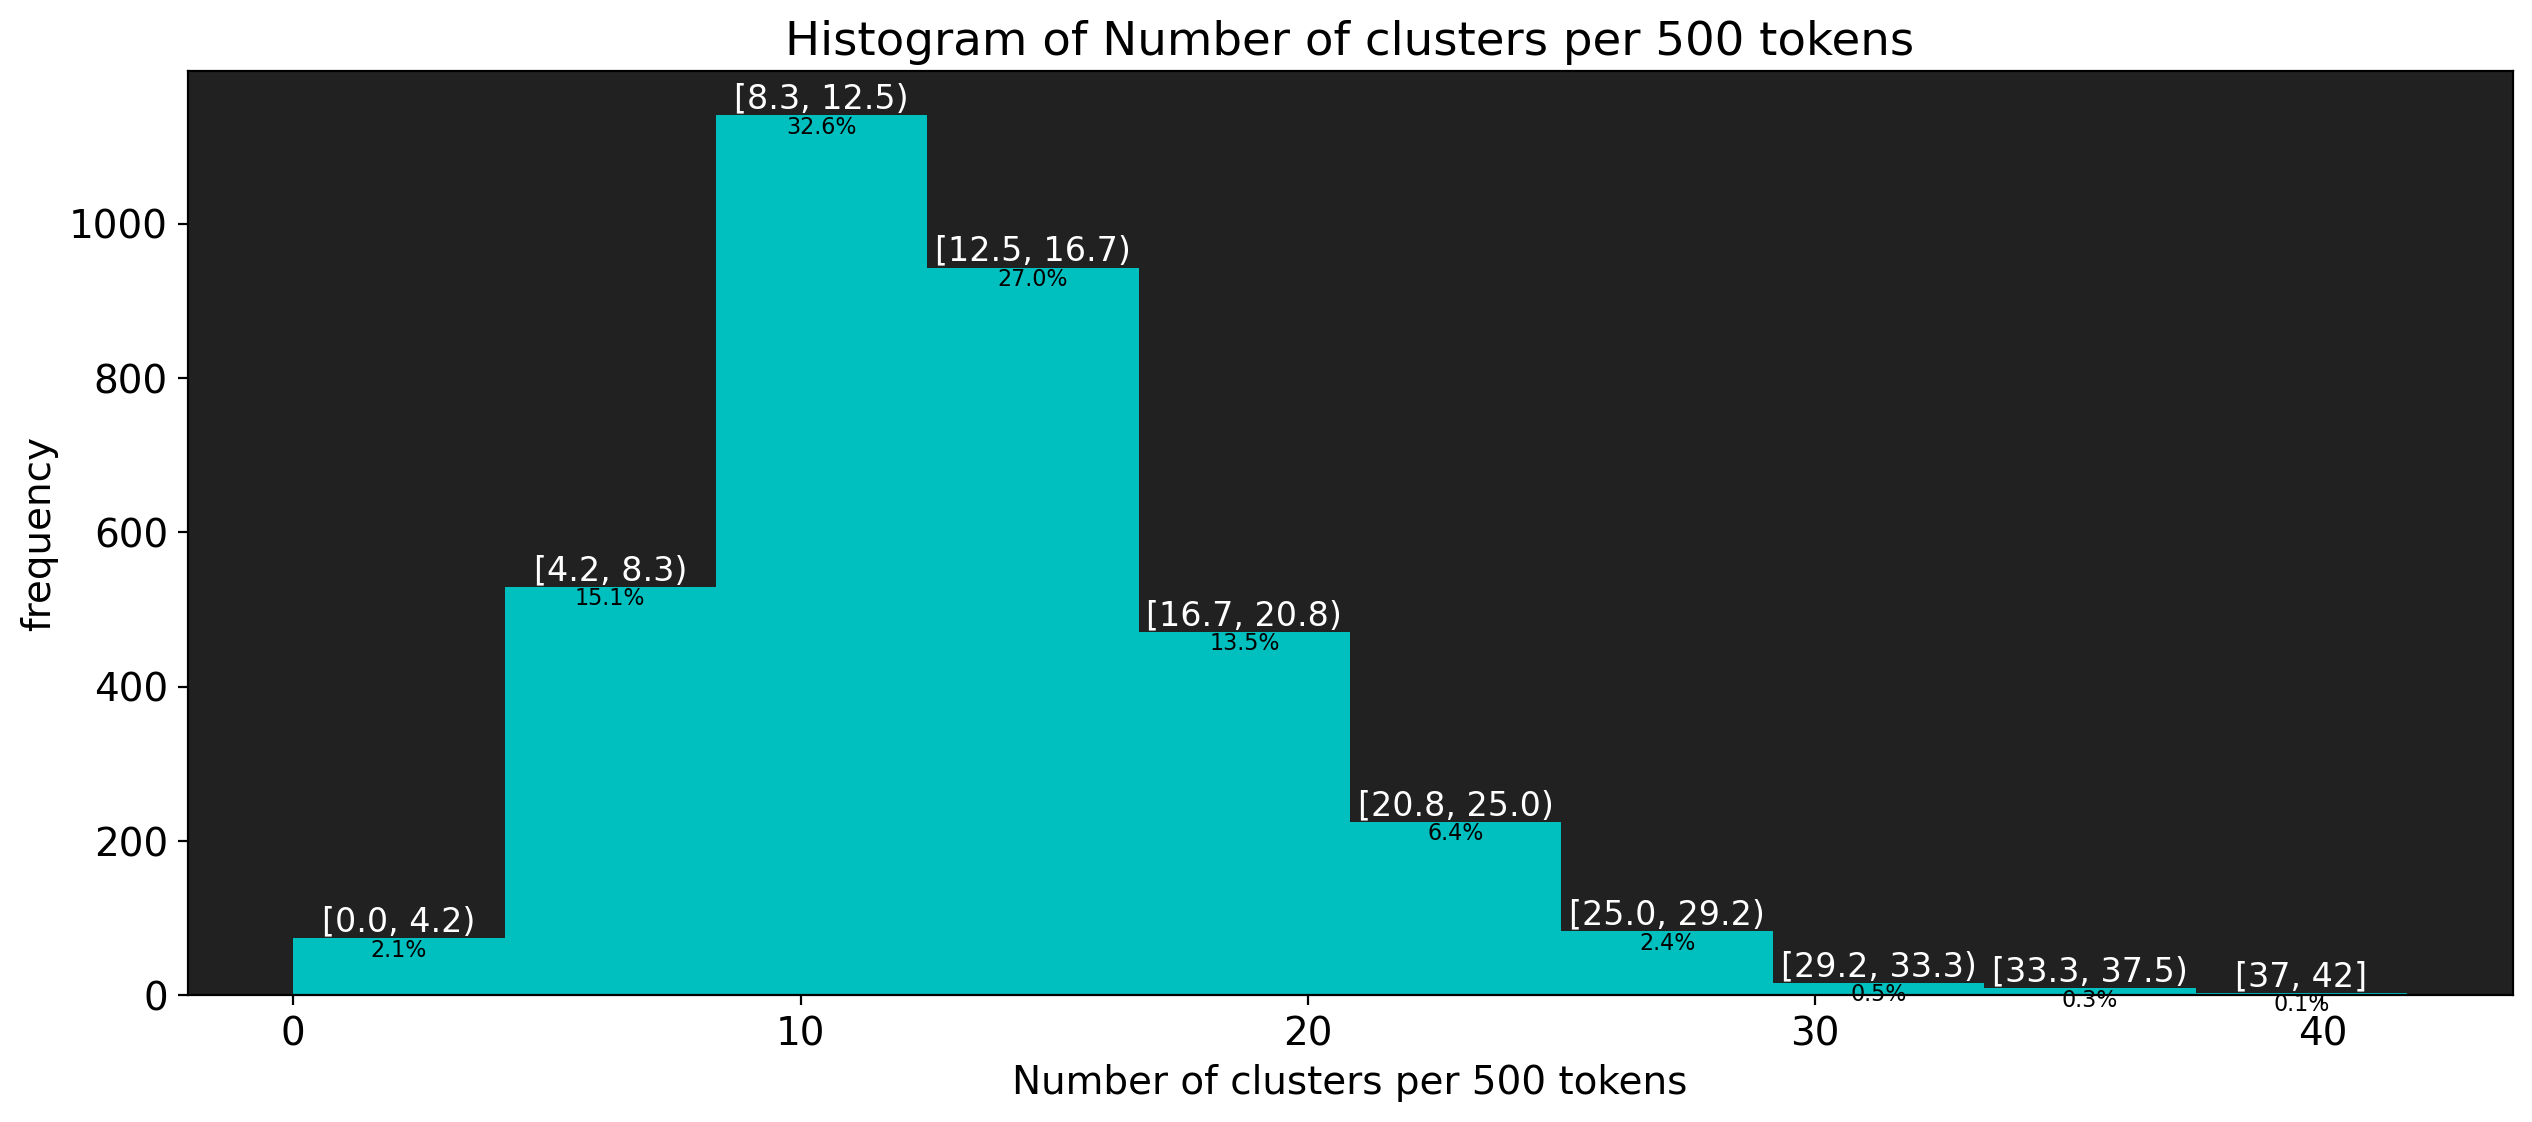

In [9]:
describe(n_clusters_per_500_tokens, "Number of clusters per 500 tokens")

Number of mentions per cluster.

Number of mentions per cluster:
	Mean +- std             = 4.40 +- 6.15
	[Min, Max]              = [2, 216]
	quantiles: 50% (median) = 2.00, 75% = 4.00, 90% = 8.00, 95% = 14.00



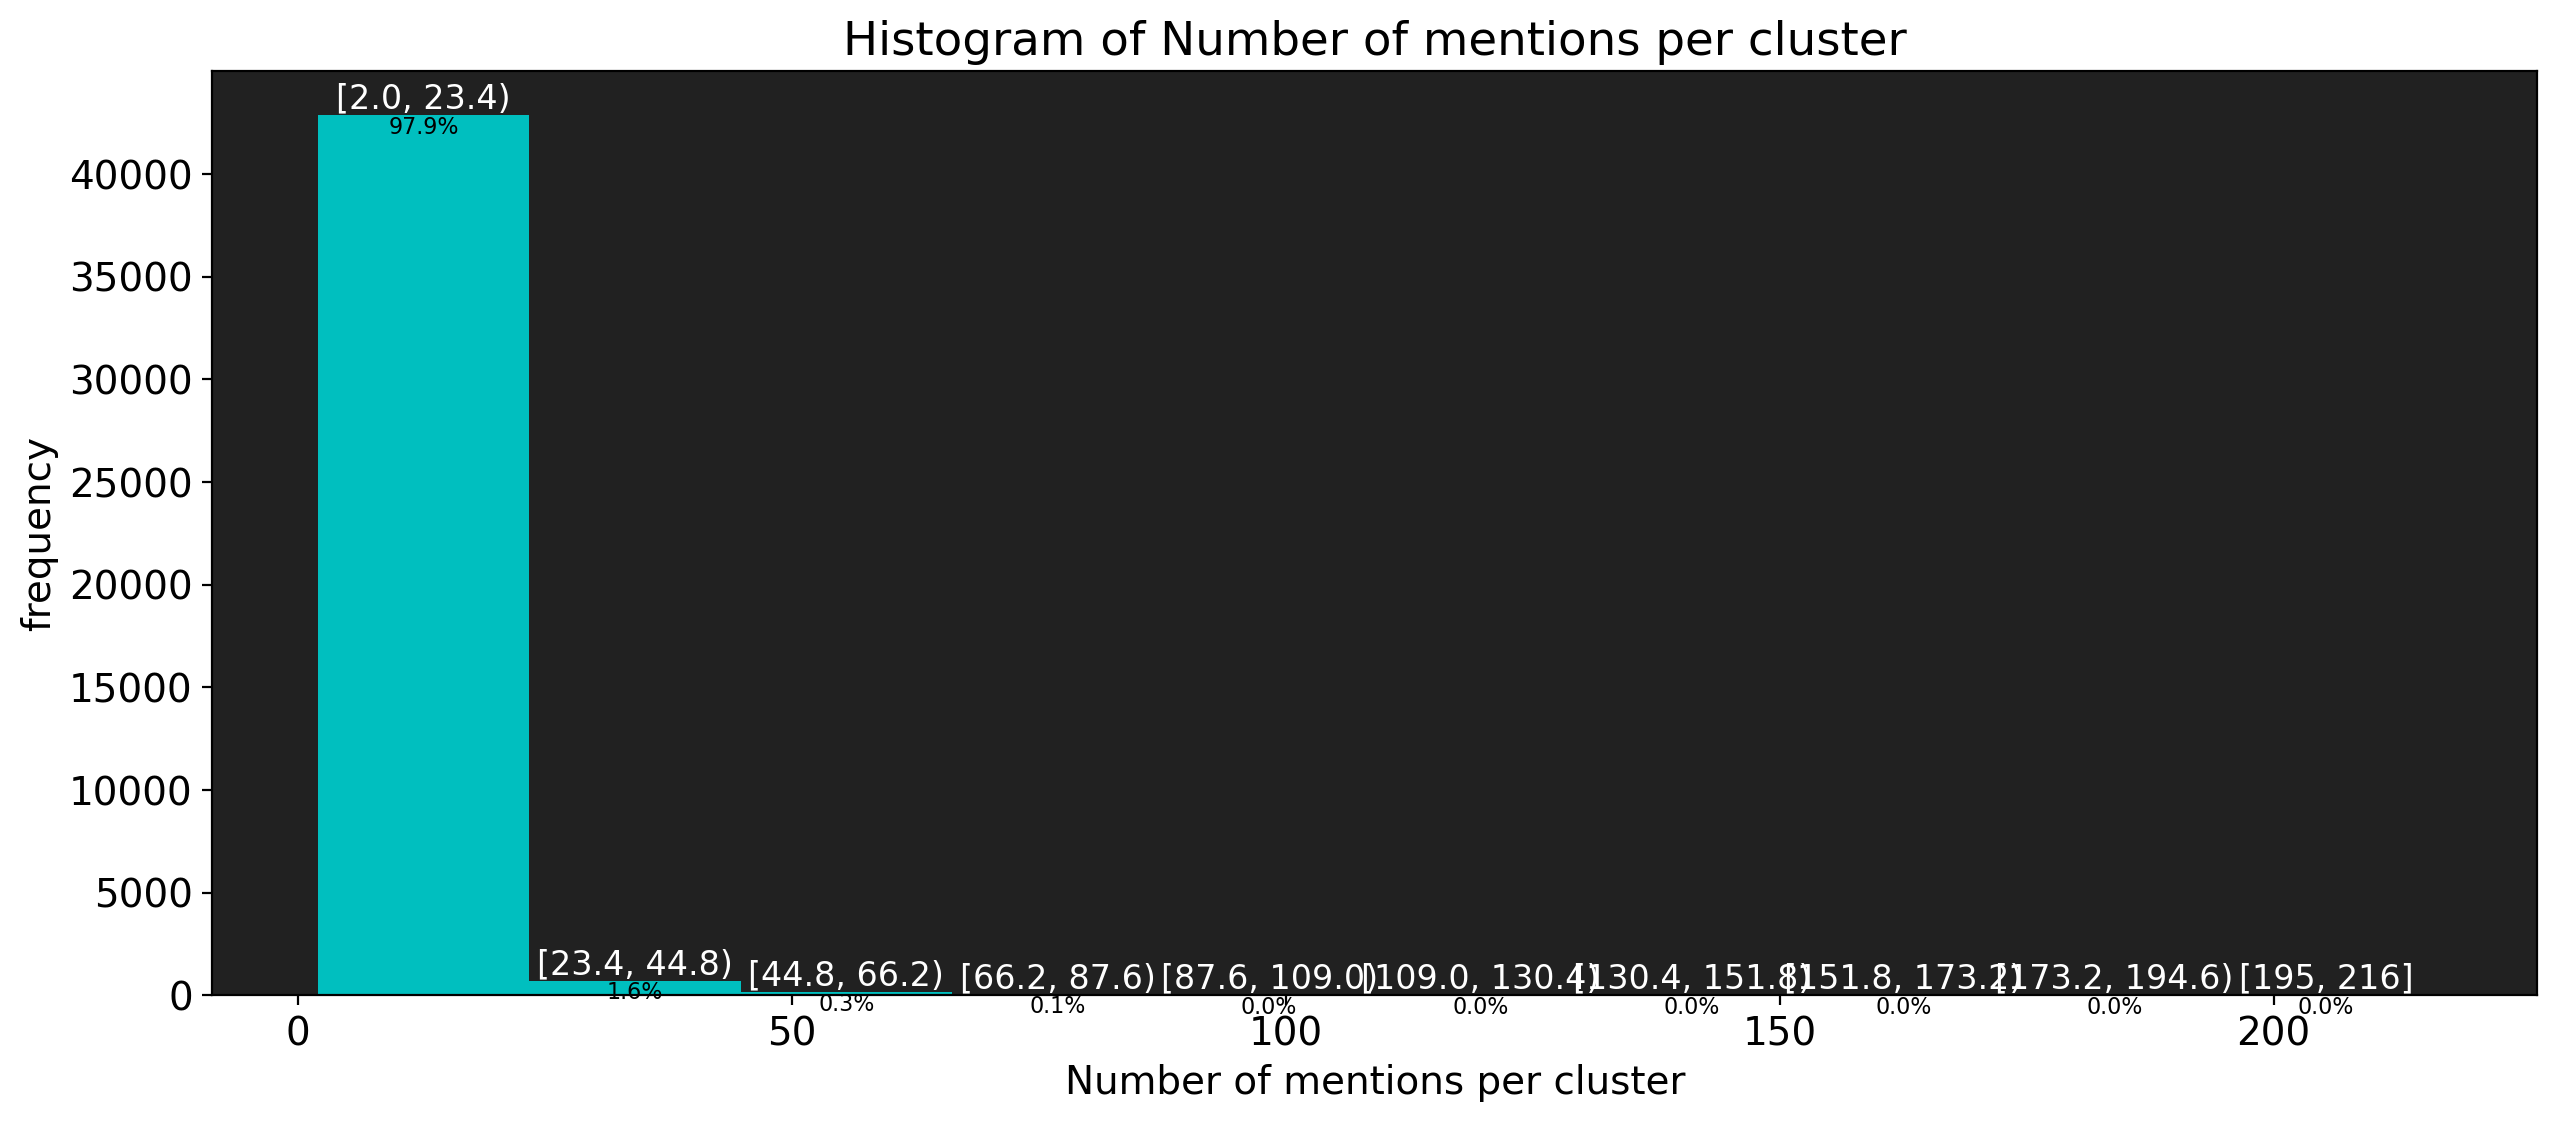

In [10]:
describe(n_mentions_per_cluster, "Number of mentions per cluster")

Number of mentions per cluster (only consider clusters with <= 15 mentions)

Number of mentions per coreference chain (mentions <= 15):
	Mean +- std             = 3.39 +- 2.42
	[Min, Max]              = [2, 15]
	quantiles: 50% (median) = 2.00, 75% = 4.00, 90% = 6.00, 95% = 9.00



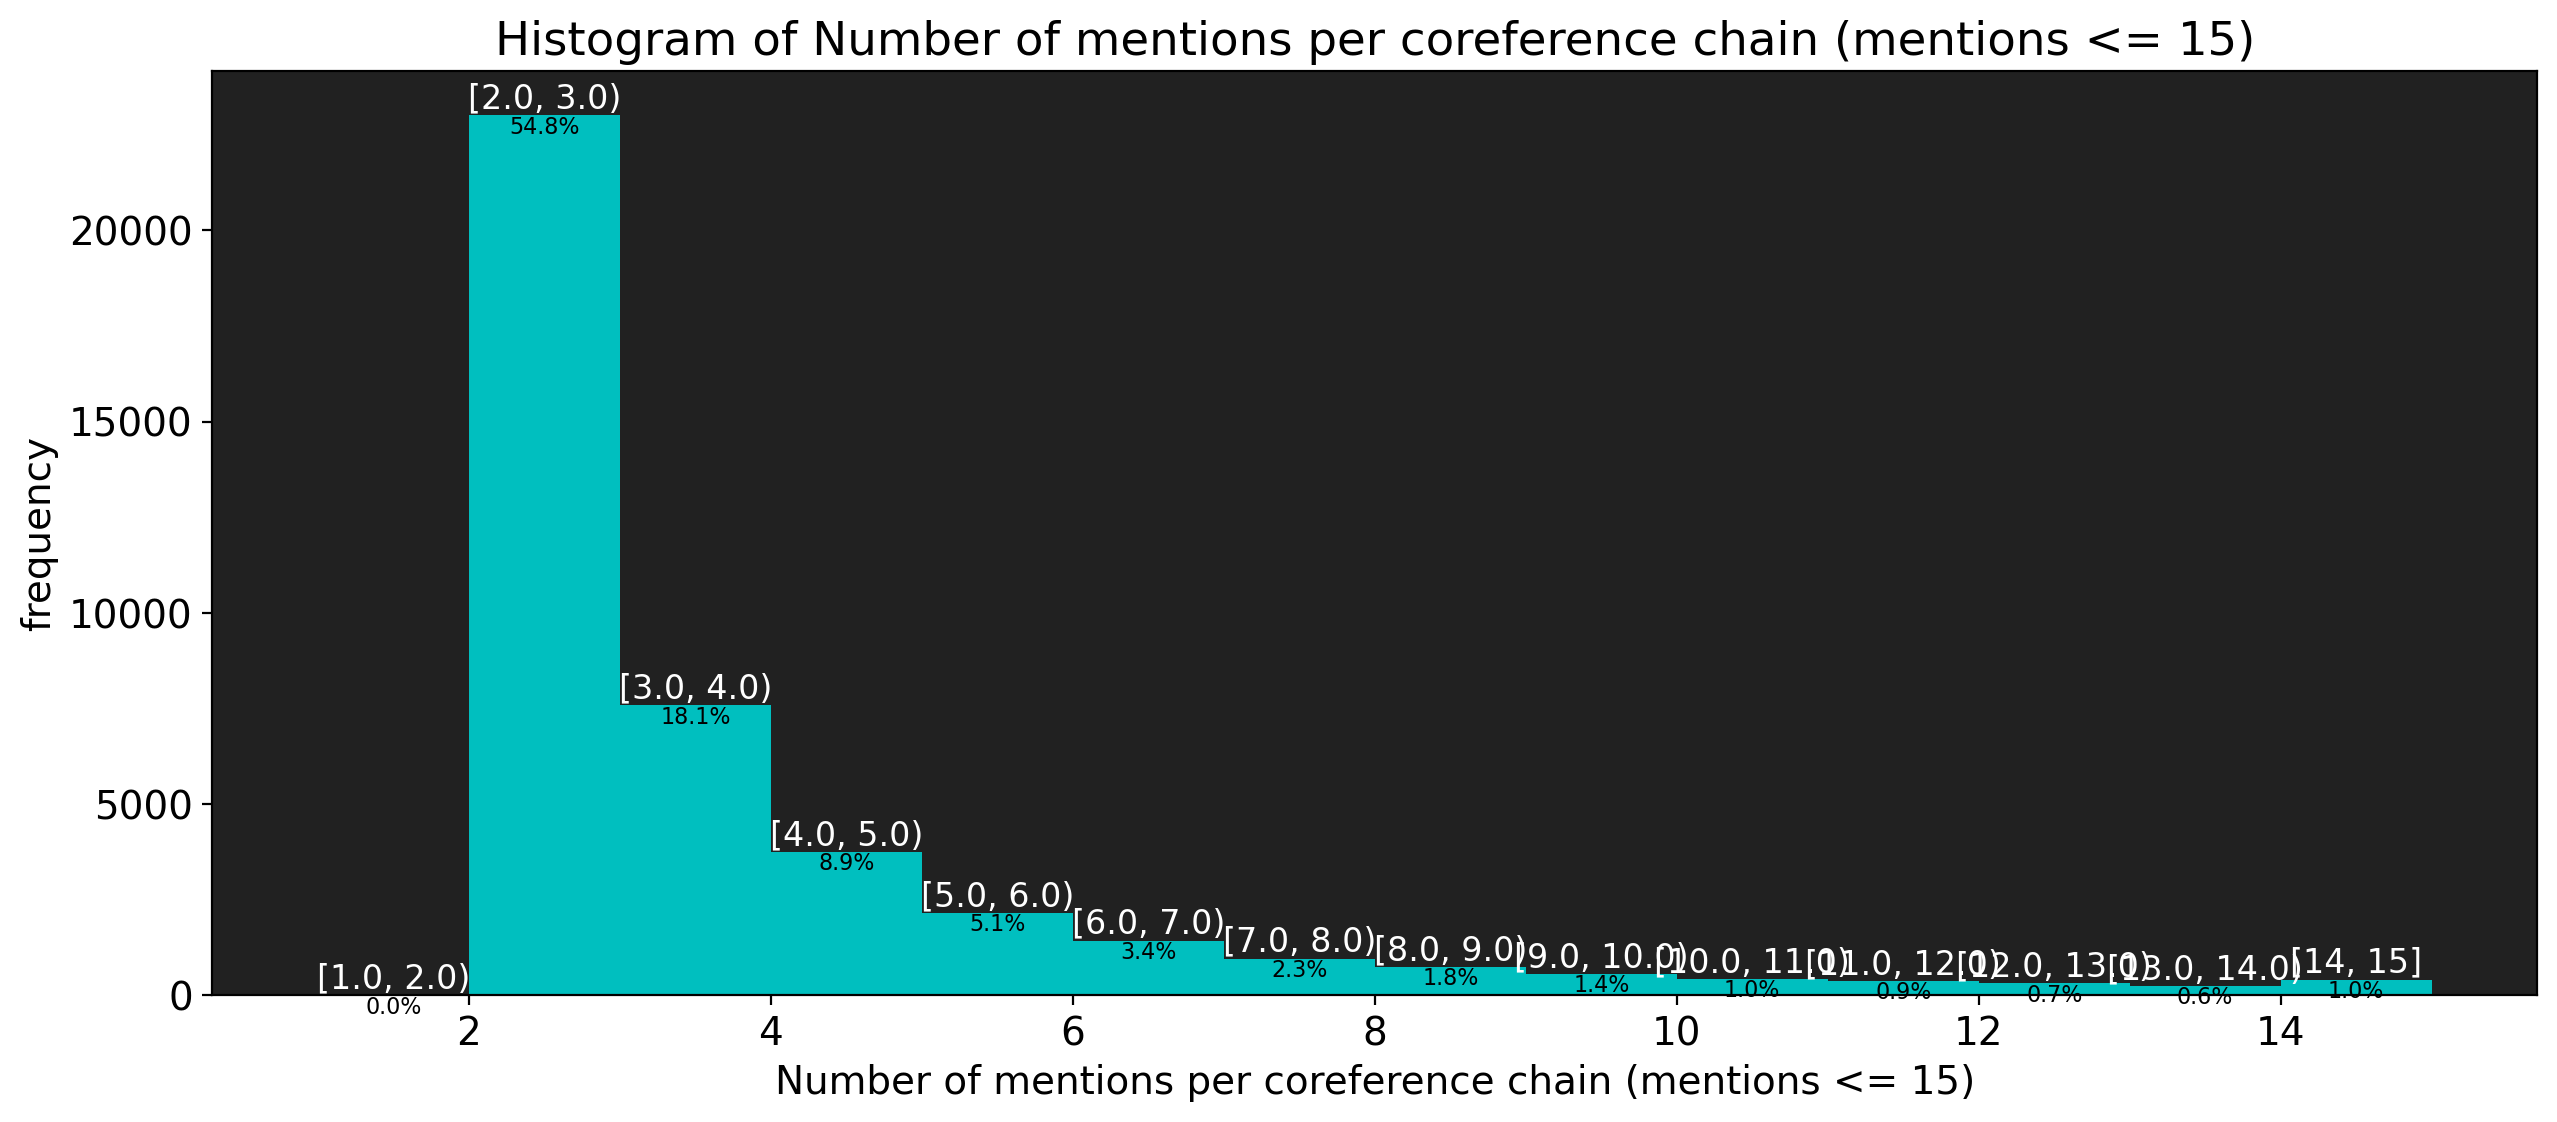

In [11]:
n_mentions_per_cluster_less_than_15 = np.array(n_mentions_per_cluster)
n_mentions_per_cluster_less_than_15 = n_mentions_per_cluster_less_than_15[
    n_mentions_per_cluster_less_than_15 <= 15]
describe(n_mentions_per_cluster_less_than_15,
        "Number of mentions per coreference chain (mentions <= 15)",
        bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

Number of tokens between successive mentions

Number of tokens between successive mentions:
	Mean +- std             = 48.34 +- 111.00
	[Min, Max]              = [0, 4344]
	quantiles: 50% (median) = 14.00, 75% = 40.00, 90% = 116.00, 95% = 213.00



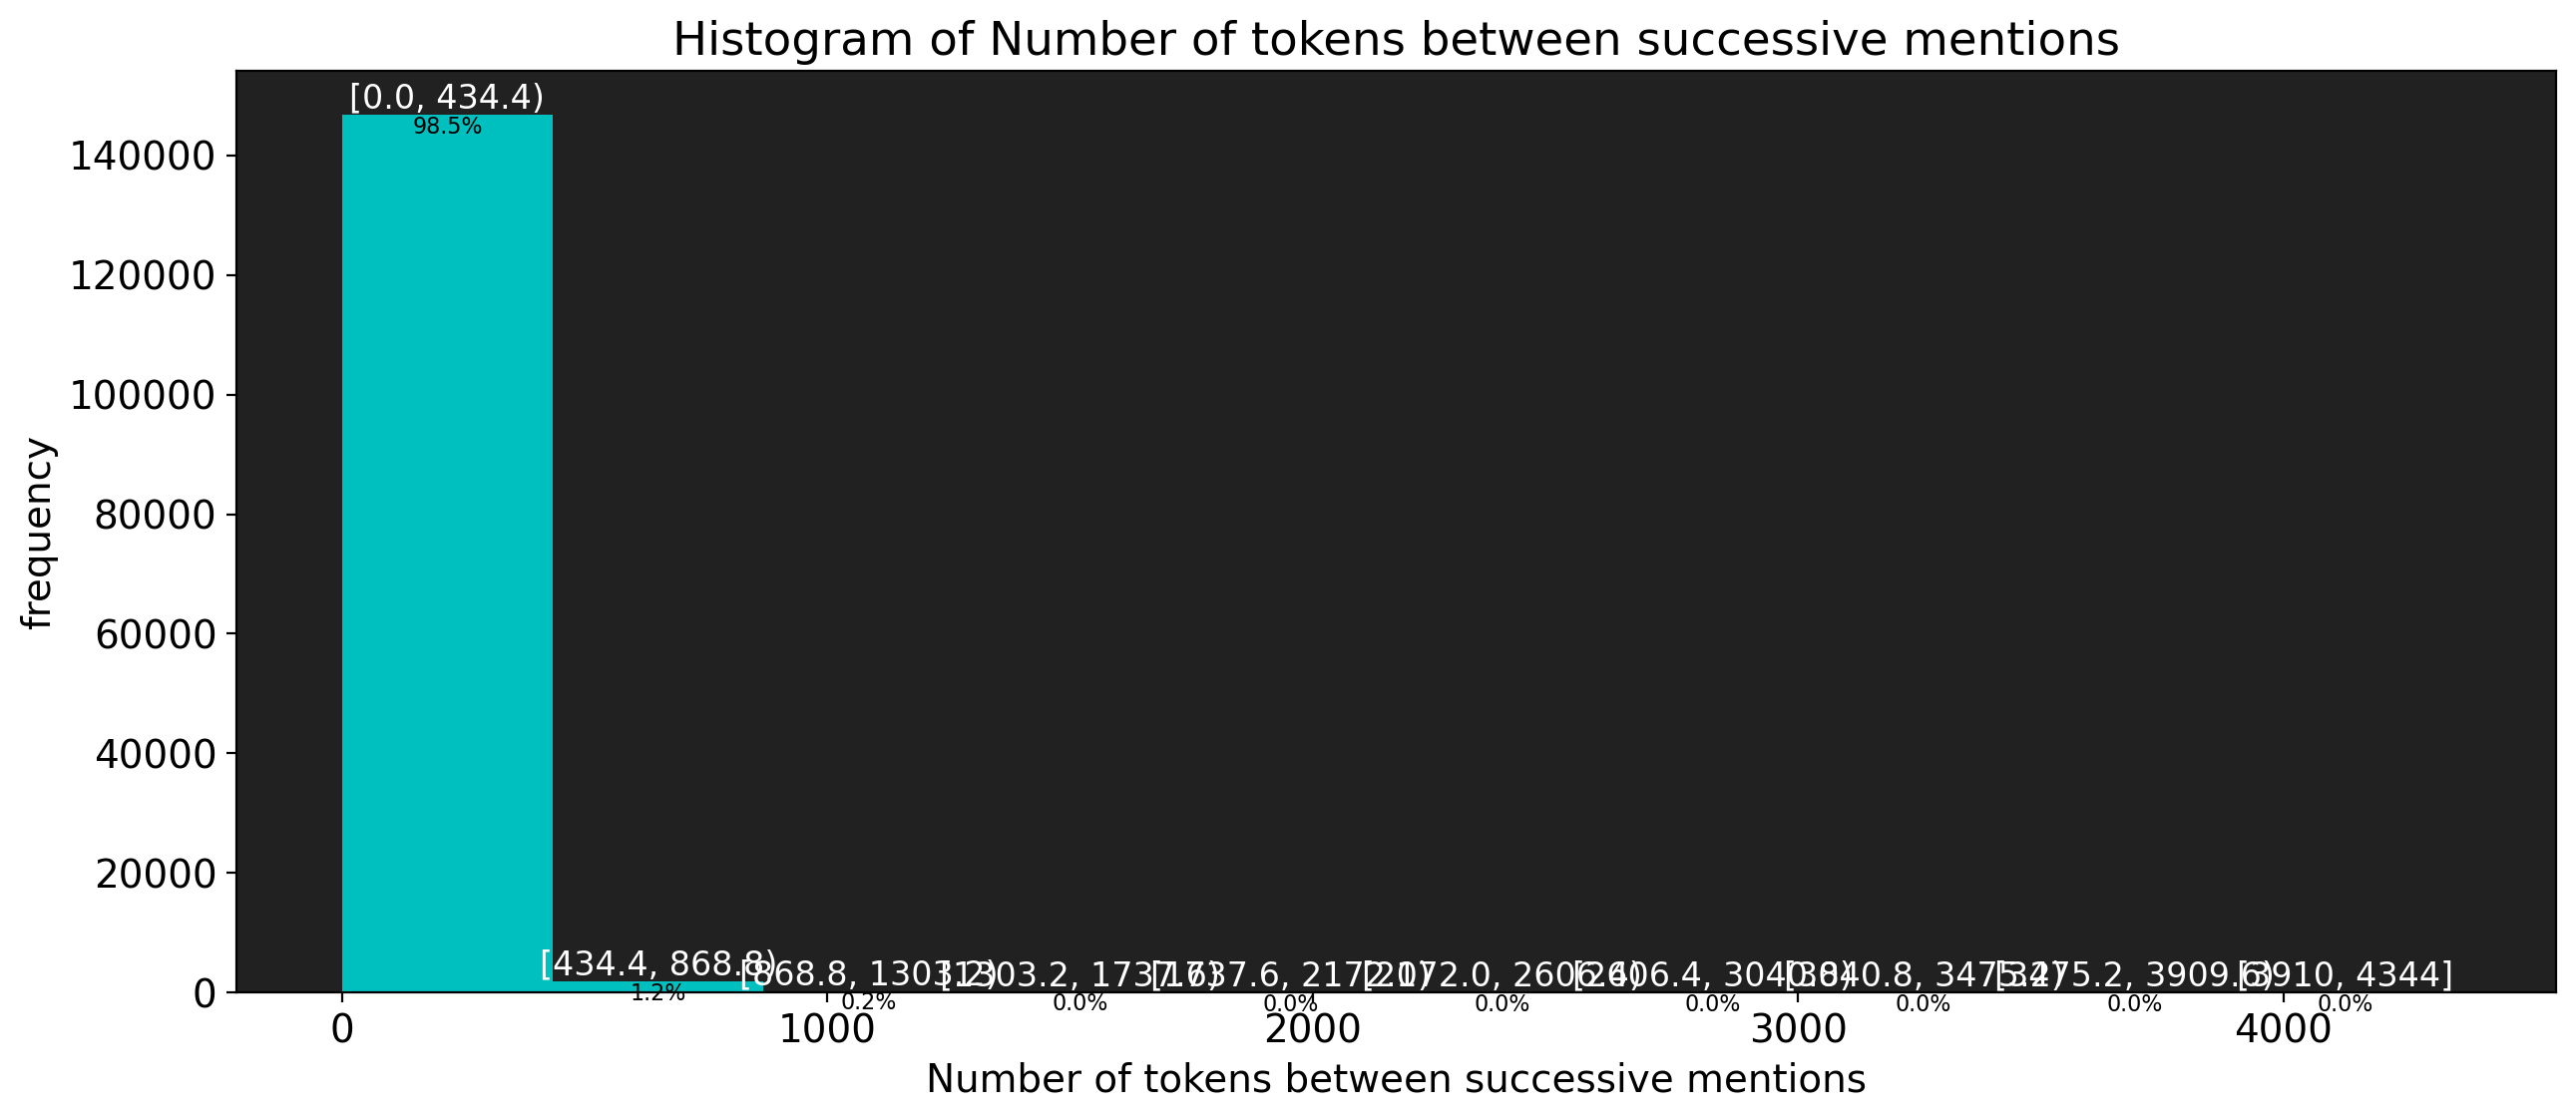

In [12]:
describe(n_tokens_between_successive_mentions,
        "Number of tokens between successive mentions")

Number of tokens between successive mentions (only consider cases where 
successive mentions are <= 100 mentions apart)

Number of tokens between successive mentions (<= 100):
	Mean +- std             = 20.09 +- 21.46
	[Min, Max]              = [0, 100]
	quantiles: 50% (median) = 12.00, 75% = 27.00, 90% = 53.00, 95% = 70.00



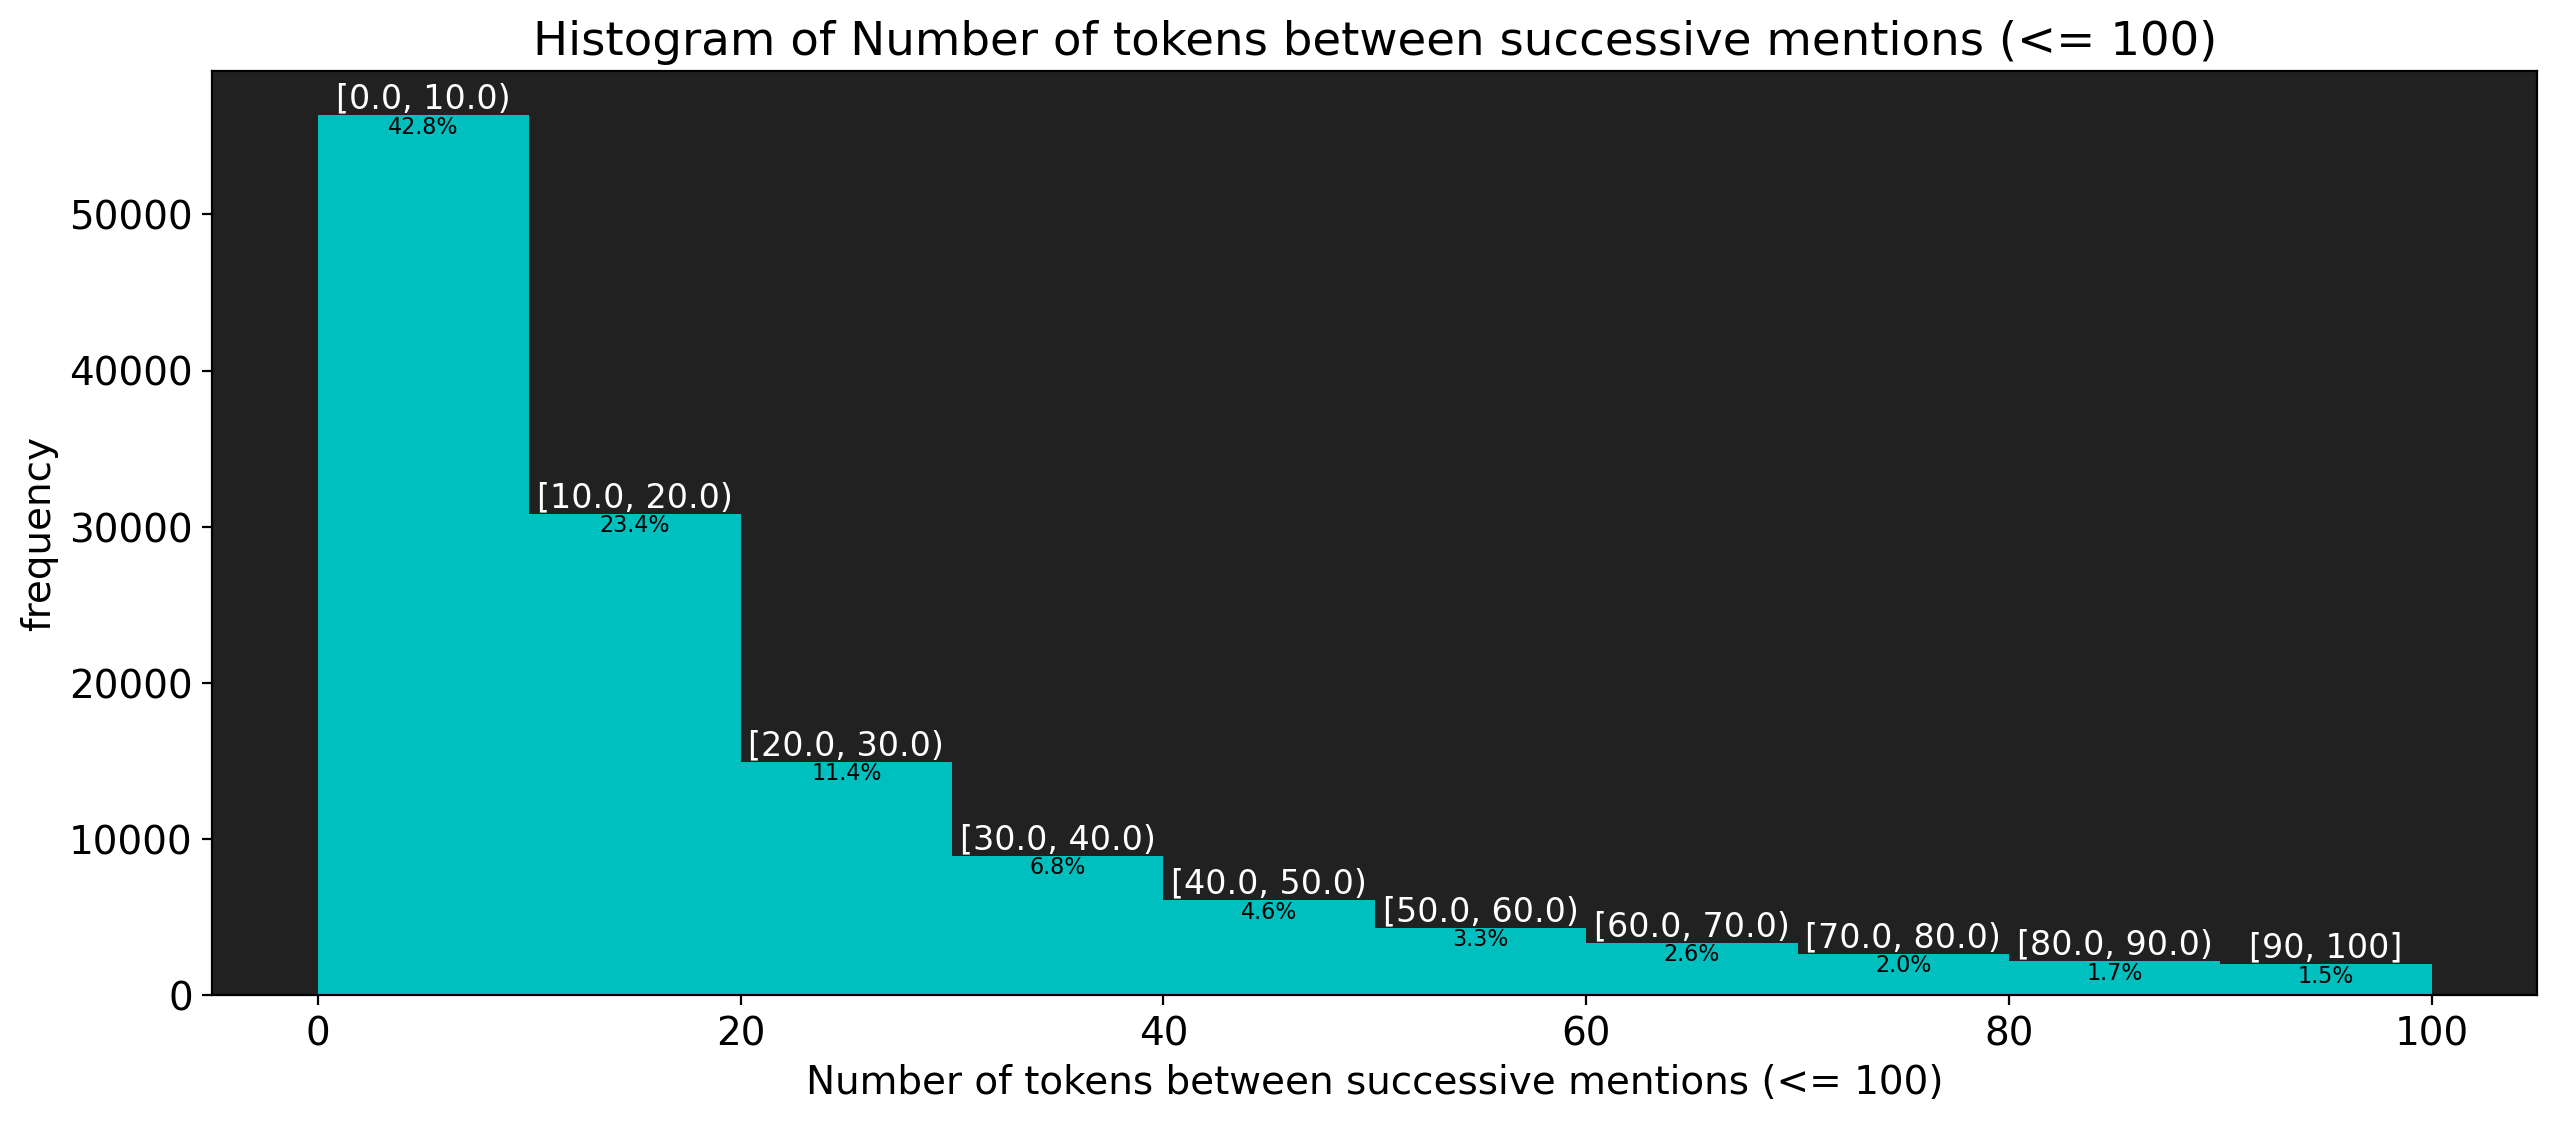

In [13]:
n_tokens_between_successive_mentions_less_than_100 = np.array(
    n_tokens_between_successive_mentions)
n_tokens_between_successive_mentions_less_than_100 = (
    n_tokens_between_successive_mentions_less_than_100[
        n_tokens_between_successive_mentions_less_than_100 <= 100])
describe(n_tokens_between_successive_mentions_less_than_100,
        "Number of tokens between successive mentions (<= 100)")

Functions to find the independent partition of coreference clusters.

In [14]:
def mentions_overlap(first_mention: data.Mention,
                    second_mention: data.Mention) -> bool:
    """Returns true if mentions overlap."""
    return first_mention.begin <= second_mention.end and (
        second_mention.begin <= first_mention.end)

def clusters_overlap(first_cluster: set[data.Mention],
                    second_cluster: set[data.Mention]) -> bool:
    """Returns true if clusters overlap."""
    sorted_first_cluster = sorted(first_cluster)
    sorted_second_cluster = sorted(second_cluster)
    i, j = 0, 0
    while i < len(sorted_first_cluster) and j < len(sorted_second_cluster):
        if mentions_overlap(sorted_first_cluster[i], sorted_second_cluster[j]):
            return True
        elif sorted_first_cluster[i] < sorted_second_cluster[j]:
            i += 1
        else:
            j += 1
    return False

def create_adjacency_matrix(clusters: list[set[data.Mention]]) -> (
    np.ndarray):
    """Create adjacency matrix based on whether the clusters overlap with each
    other. Let cluster A contain mentions x1, x2, ..., xn, and let cluster B
    contain mentions y1, y2, ..., ym. A overlaps with B if there exists mentions
    xi and yj such that xi and yj overlap with each other. An entry in the
    adjacency matrix contains 1 if the row cluster overlaps with the column cluster.
    """
    adjacency_matrix = np.zeros((len(clusters), len(clusters)), dtype=int)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            adjacency_matrix[i, j] = adjacency_matrix[j, i] = int(
                clusters_overlap(clusters[i], clusters[j]))
    return adjacency_matrix

def find_lowest_degree_vertex(adjacency_matrix: np.ndarray, 
                            vertices: list[int]) -> int:
    """Find the vertex index with the lowest degree in the subgraph defined
    by the vertex_indexes set. If vertex_indexes is empty, return -1.
    """
    if len(vertices) == 0:
        return -1
    vertex_degrees: list[int] = [0 for _ in range(len(vertices))]
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            u = vertices[i]
            v = vertices[j]
            if adjacency_matrix[u, v] == 1:
                vertex_degrees[i] += 1
                vertex_degrees[j] += 1
    return vertices[np.argmin(vertex_degrees)]

def approx_min_independent_partition(clusters: list[set[data.Mention]]) -> (
    list[list[set[data.Mention]]]):
    """Solve the minimum independent partition problem approximately. Given an
    undirected graph G = (V, E), a partition of V into V1, V2, V3, ..., Vk is
    an independent partition if each of the Vi's is an independent set, any pair
    Vi and Vj are mutually disjoint, and the union of all the Vi's equals V.
    The minimum independent partition problem finds the minimum sized partition
    i.e. the partition which minimizes k. This is an NP-hard problem. We approximate
    the solution by iteratively selecting the lowest-degree vertex, adding it to
    the current partition set, and removing its neighbours. We repeat this
    until we exhaust all the vertices.
    """
    adjacency_matrix = create_adjacency_matrix(clusters)
    vertex_set = set(range(len(clusters)))
    partition: list[set[int]] = []

    while vertex_set:
        remaining_vertices = vertex_set
        excluded_vertices: set[int] = set()
        included_vertices: set[int] = set()
        while remaining_vertices:
            lowest_degree_vertex = find_lowest_degree_vertex(
                adjacency_matrix, list(remaining_vertices))
            neighbours = set([vertex for vertex in remaining_vertices
                                if vertex != lowest_degree_vertex and (
                                adjacency_matrix[vertex][lowest_degree_vertex])
                                    == 1])
            remaining_vertices = remaining_vertices.difference(
                set([lowest_degree_vertex]).union(neighbours))
            included_vertices.update(set([lowest_degree_vertex]))
            excluded_vertices.update(neighbours)
        partition.append(included_vertices)
        vertex_set = excluded_vertices
    
    partition_clusters = [[clusters[vertex] for vertex in vertices]
                            for vertices in partition]
    return partition_clusters

Find cluster partitions of corpus.

In [15]:
n_cluster_partitions_per_document = []
n_cluster_partitions_per_500_tokens = []

for document in tqdm.tqdm(bert_corpus.documents):
    n_tokens = sum(len(sentence) for sentence in document.sentences)
    cluster_partition = approx_min_independent_partition(document.clusters)
    n_cluster_partitions_per_document.append(len(cluster_partition))
    n_cluster_partitions_per_500_tokens.append(500*len(cluster_partition)/
        n_tokens)

100%|██████████| 3493/3493 [00:03<00:00, 882.31it/s] 


Number of cluster partitions per document.

Number of cluster partitions per document:
	Mean +- std             = 2.14 +- 0.82
	[Min, Max]              = [0, 5]
	quantiles: 50% (median) = 2.00, 75% = 3.00, 90% = 3.00, 95% = 3.00



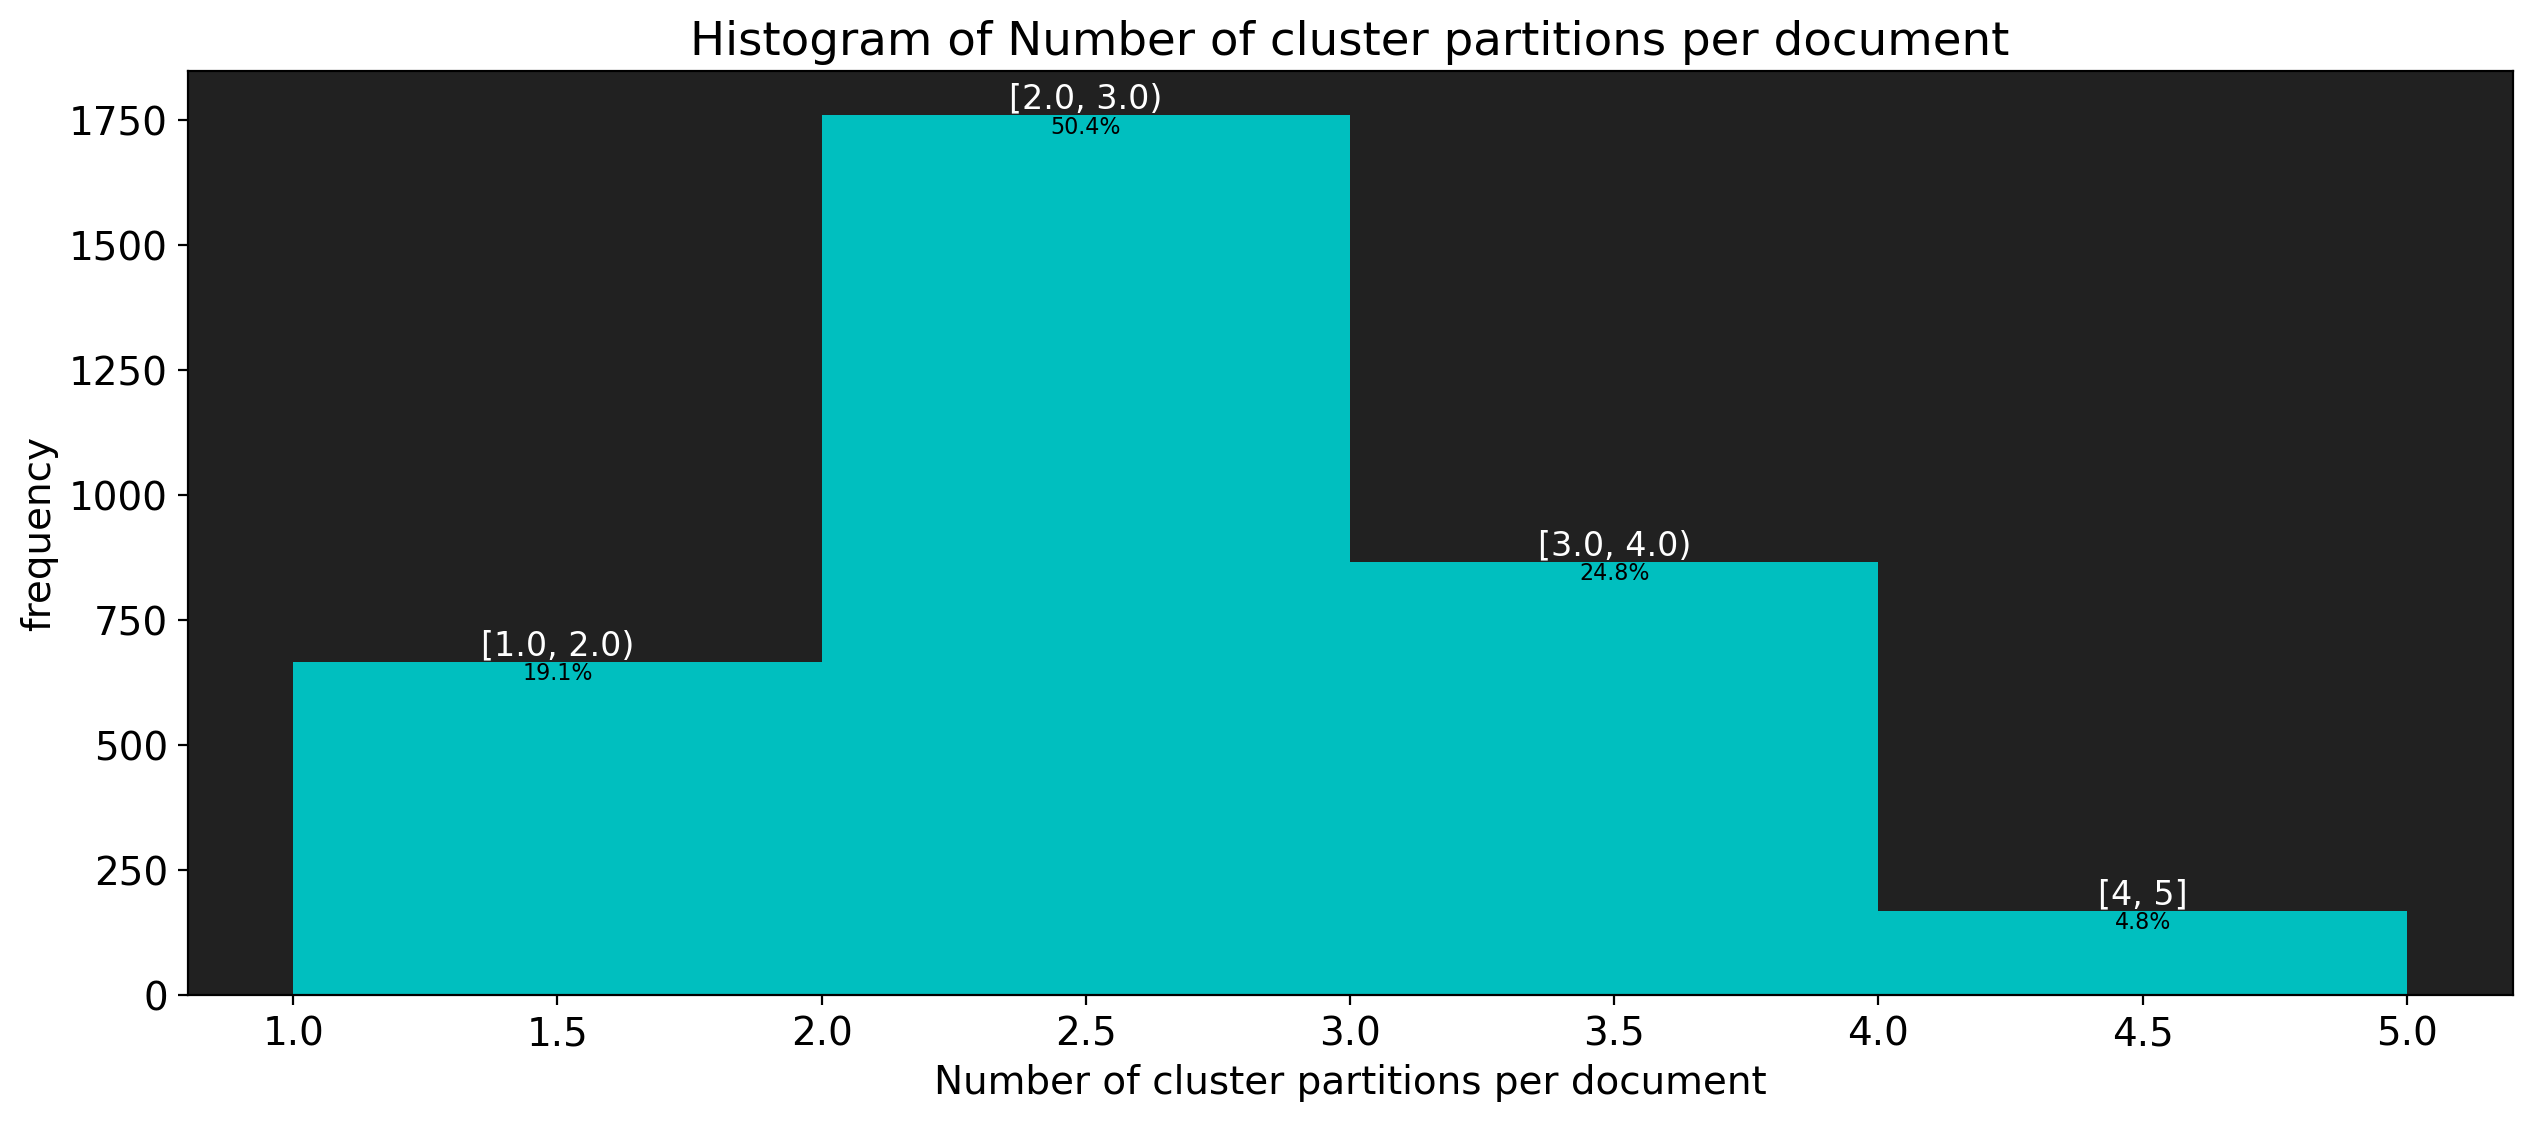

In [16]:
describe(n_cluster_partitions_per_document, 
            "Number of cluster partitions per document", bins=[1,2,3,4,5])

Number of cluster partitions per 500 tokens.

Number of cluster partitions per 500 tokens:
	Mean +- std             = 3.59 +- 3.36
	[Min, Max]              = [0.0, 29.069767441860463]
	quantiles: 50% (median) = 2.37, 75% = 4.42, 90% = 7.94, 95% = 10.67



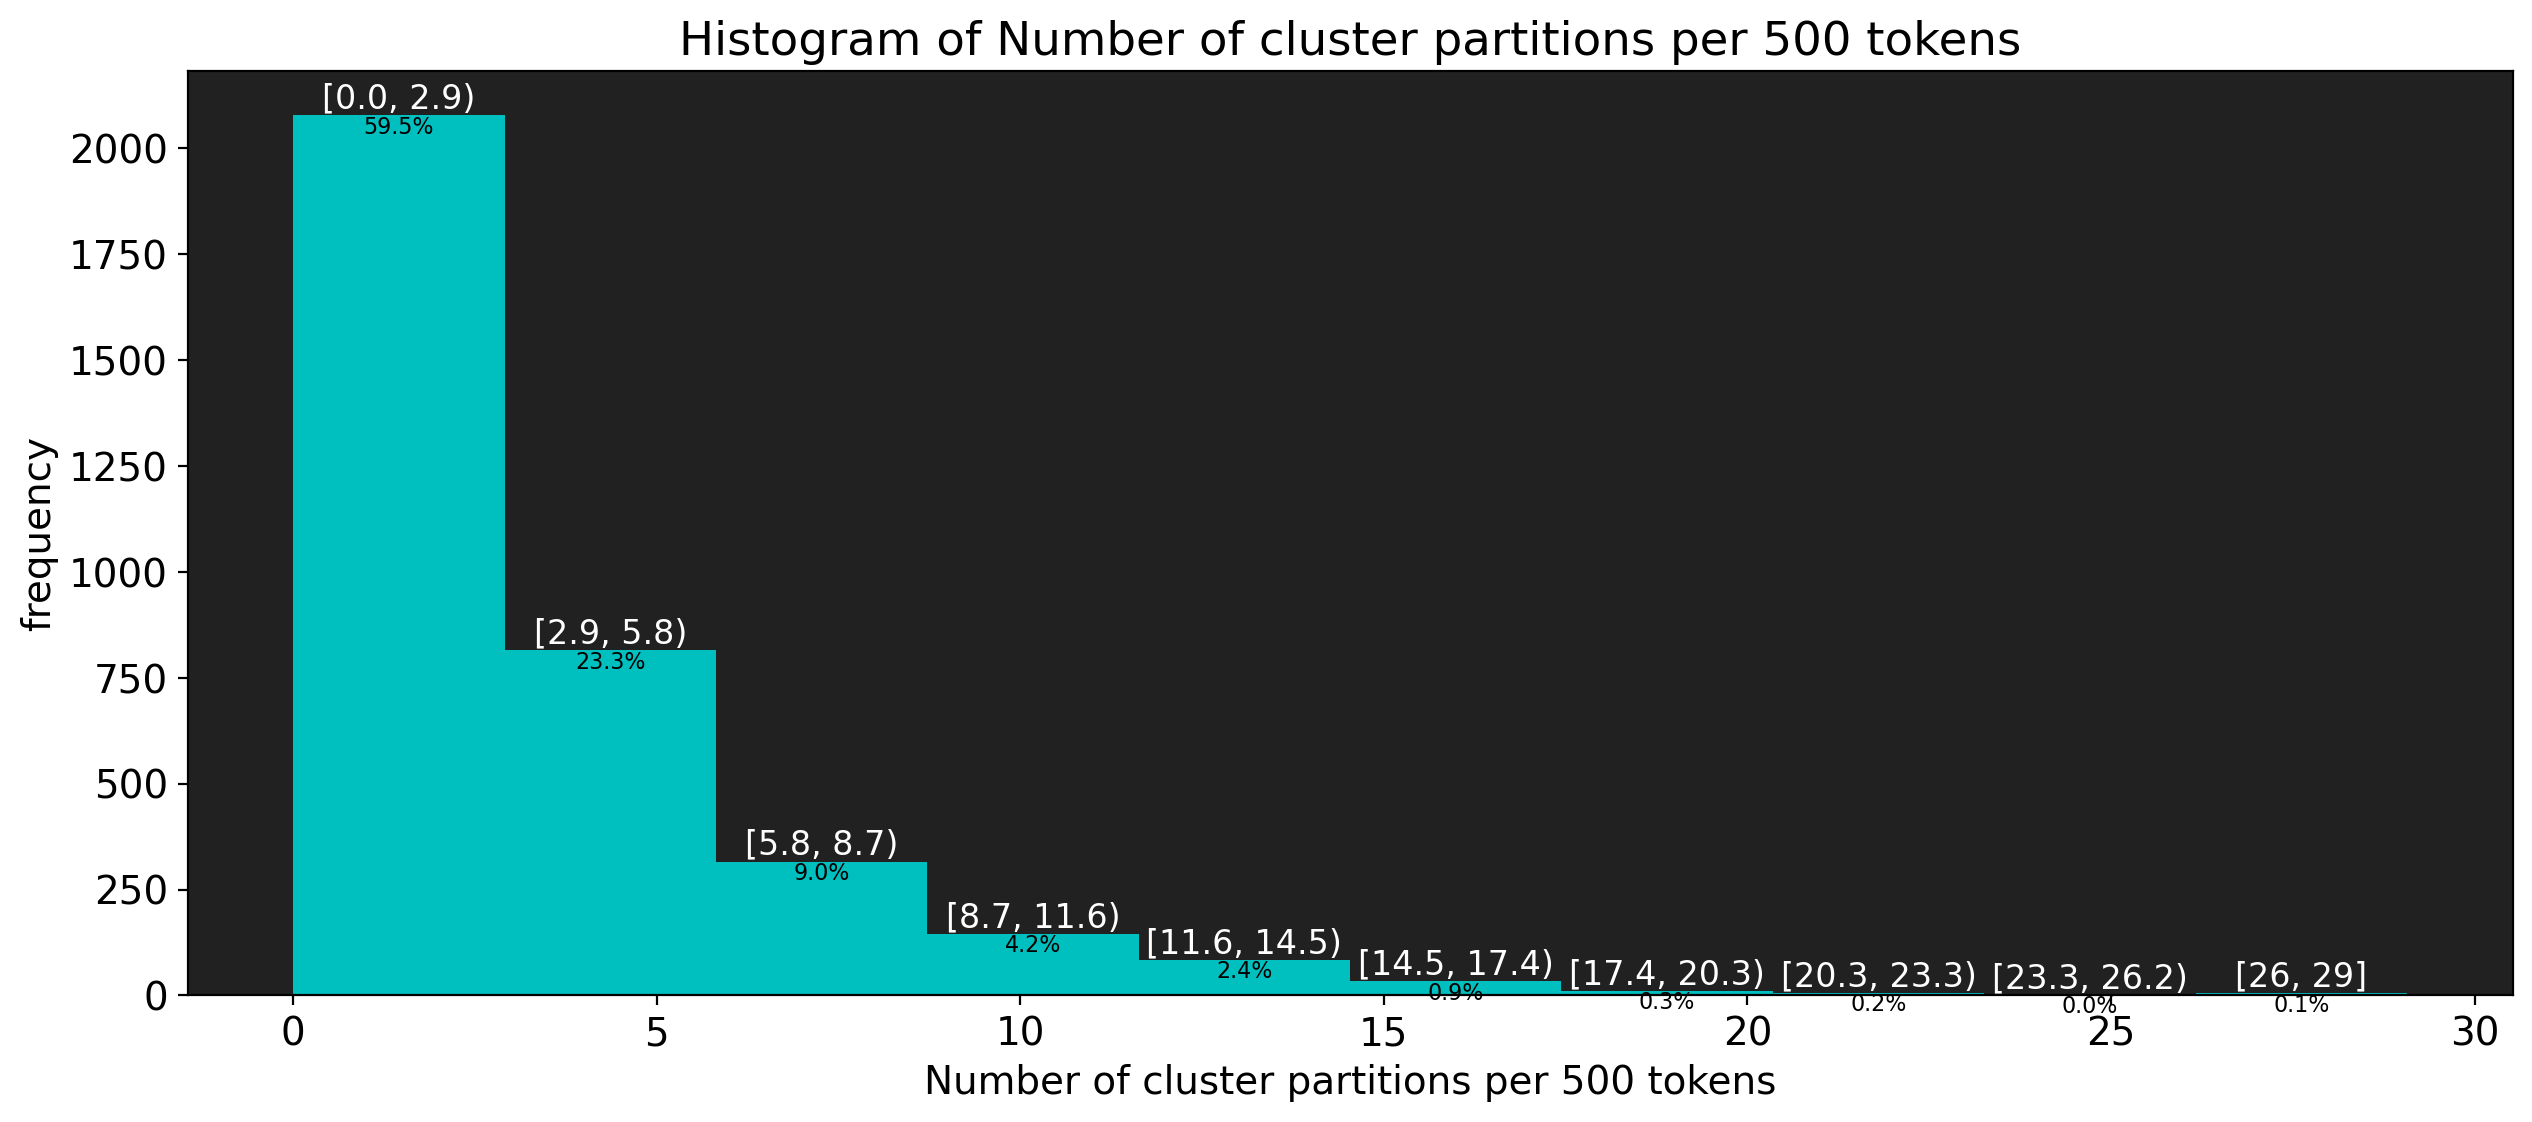

In [17]:
describe(n_cluster_partitions_per_500_tokens, 
    "Number of cluster partitions per 500 tokens")